# FLIGHT PRICE PREDICTION

### PROBLEM STATEMENT

Anyone who has booked a flight ticket knows how unexpectedly the prices vary. The cheapest 
available ticket on a given flight gets more and less expensive over time. This usually happens as 
an attempt to maximize revenue based on -
1. Time of purchase patterns (making sure last-minute purchases are expensive)
2. Keeping the flight as full as they want it (raising prices on a flight which is filling up in order 
to reduce sales and hold back inventory for those expensive last-minute expensive 
purchases)
So, you have to work on a project where you collect data of flight fares with other features and 
work to make a model to predict fares of flights.


In [1]:
#Importing necessary libraries

# Preprocessing
import numpy as np
import pandas as pd
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy as stats
from scipy.stats import zscore   # To remove outliers
# Evaluation Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn import metrics
# ML Algorithms
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
#getting data
os.chdir("C:\GitBash\Files")
df = pd.read_excel("Flight_Prices.xlsx")

Here we are importing the colleced dataset which is in excel format and storing it into dataframe (df) for further usage. Here we can observe first 5 and last 5 rows of the dataset. There are 5303 rows and 9 columns in the dataframe. The dataset contains both numerical and categorical data. There are both dependent and independent variables present in the dataframe. We have our target variable "Price" which stores the price of the flight tickets and it is continuous in nature which makes this problem to be a "Regression Problem".

### DATA CLEANING

In [3]:
# Checking the dimensions of the dataset
print("There are {} rows and {} columns in our dataframe".format(df.shape[0], df.shape[1]))


There are 5303 rows and 9 columns in our dataframe


The dataset contains 5303 rows and 9 columns. Out of 9 columns 8 are independent variables and remaining one is our target variable "Price" which is dependent variable.

In [4]:

# Checking the column names in the dataset
print("Columns present in our dataset:\n",df.columns)


     

Columns present in our dataset:
 Index(['Airline', 'Departure_time', 'Time_of_arrival', 'Duration', 'Source',
       'Destination', 'Meal_availability', 'Number_of_stops', 'Price'],
      dtype='object')


In [5]:

# Checking number of unique values in each column of dataset
df.nunique().to_frame("No of Unique Values")


,No of Unique Values
Airline,6
Departure_time,247
Time_of_arrival,253
Duration,398
Source,8
Destination,9
Meal_availability,3
Number_of_stops,5
Price,1711


In [6]:

# To get good overview of the dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5303 entries, 0 to 5302
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Airline            5303 non-null   object
 1   Departure_time     5303 non-null   object
 2   Time_of_arrival    5303 non-null   object
 3   Duration           5303 non-null   object
 4   Source             5303 non-null   object
 5   Destination        5303 non-null   object
 6   Meal_availability  5303 non-null   object
 7   Number_of_stops    5303 non-null   object
 8   Price              5303 non-null   object
dtypes: object(9)
memory usage: 373.0+ KB


In [7]:
# Checking null values in the dataset
df.isnull().sum()


Airline              0
Departure_time       0
Time_of_arrival      0
Duration             0
Source               0
Destination          0
Meal_availability    0
Number_of_stops      0
Price                0
dtype: int64

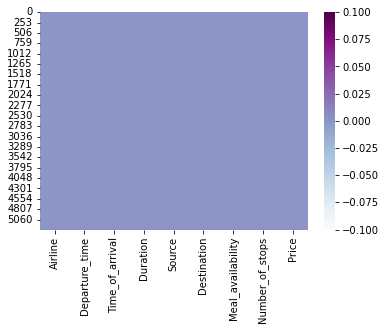

In [8]:

# Let's visualize the null values clearly
sns.heatmap(df.isnull(),cmap="BuPu")
plt.show()


Here we can clearly observe there are no missing values.

### Feature Engineering
The columns Time_of_arrival and Departure_Time showing object data type which means python is not able to understand the type of data in this column due to some string values or categorical signs like ":" which we can observe in the value count function. Therefore, we have to convert this datatype into timestamp (datetime) to use them properly for prediction.

In [10]:

# Converting columns from object type to Datetime Type
df["Departure_time"] = pd.to_datetime(df["Departure_time"])
df["Time_of_arrival"] = pd.to_datetime(df["Time_of_arrival"])


In [11]:
#Checking the data types of all columns again
df.dtypes

Airline                      object
Departure_time       datetime64[ns]
Time_of_arrival      datetime64[ns]
Duration                     object
Source                       object
Destination                  object
Meal_availability            object
Number_of_stops              object
Price                        object
dtype: object

### Duration
The column Duration has values in terms of minutes and hours. Duration means the time taken by the plane to reach the destination and it is the difference between the arrival time and Departure time. Let's extract proper duration time in terms of float data type from Time_of_arrival and Departure_time columns.

In [12]:

#Extracting Duration column using Time_of_arrival and Departure_Time
Difference = (df["Time_of_arrival"]-df["Departure_time"])
Diff_list = list()
for i in range(len(Difference)):
    duration = Difference.iloc[i].seconds/3600  # Converting difference into seconds and Dividing it by 3600 (1hr=3600seconds)
    Diff_list.append(duration)
df["Duration"] = Diff_list


## Departure_time
Let's extract values from Departure_time. Departure time means when a flight leaves the airport and this column contains hours and minutes so we will extract hours and minutes from Departure_time.

In [13]:

# Departure time means the time when the journey starts from the source.

# Extracting Hours from Departure_time column
df["Departure_Hour"] = pd.to_datetime(df["Departure_time"]).dt.hour

# Extracting Minutes from Dep_Time column
df["Departure_Min"] = pd.to_datetime(df["Departure_time"]).dt.minute


Now we have extracted hour and minute from Departure_time column. Let's drop Departure_time column as it is of no use now.

In [14]:
# Dropping Departure_time column
df.drop("Departure_time",axis=1,inplace=True)

# Time_of_arrival
Similarly we can extract hours and minutes from Time_of_arrival column and dropping Time_of_arrival column

In [15]:
# Arrival time is time of arrival at the destination.

# Extracting hour from Time_of_arrival column
df["Arrival_Hour"] = pd.to_datetime(df["Time_of_arrival"]).dt.hour

# Extracting Minutes from Arrival_Time column
df["Arrival_Min"] = pd.to_datetime(df["Time_of_arrival"]).dt.minute

# Dropping Arrival_Time column
df.drop("Time_of_arrival",axis=1,inplace=True)




## Price
The target column should be in continuous numeric data type but it is appearing as object data type due to some categorical sign ",". Let's replace this sign by empty space and convert the type into float.

In [16]:
# Let's replace "," sign by empty space
df['Price'] = df['Price'].str.replace(',','')
# Let's convert data type of Price column to float
df['Price'] = df['Price'].astype('float')


## Meal_availability
From the value count function of Meal_availability we can observe "eCash 250" entry which does not belongs to meals so we can replace it as "None". Also, the other two entries "No meal fare" and "Free meal" belongs to same category that is they give same meaning so we can group them as well. We can also drop this column, but there are only few features in the dataset so, trying to retain the columns for prediction.

In [17]:

# Replacing "eCash250" by "None"
df['Meal_availability'] = df['Meal_availability'].replace('eCash 250','None')

# Grouping the entries with same meaning
df['Meal_availability'] = df['Meal_availability'].replace('No Meal Fare','Free Meal')



## Number_of_stops
From the value count function of Number_of_stops we can observe the categorical values, let's replace them with numeric data.

In [18]:
# Replacing categorical values with numeric data
df.Number_of_stops.replace({"Non Stop": 0,"1 Stop": 1,"2 Stop(s)": 2,"3 Stop(s)": 3,"4 Stop(s)": 4},inplace = True)


In [19]:
# Checking dataset again
df


,Airline,Duration,Source,Destination,Meal_availability,Number_of_stops,Price,Departure_Hour,Departure_Min,Arrival_Hour,Arrival_Min
0,Go First,4.666667,New Delhi,Mumbai,Free Meal,1,4941.0,6,0,10,40
1,Go First,4.833333,New Delhi,Mumbai,Free Meal,1,4941.0,16,35,21,25
2,Go First,6.750000,New Delhi,Mumbai,Free Meal,1,4941.0,9,0,15,45
3,Go First,7.083333,New Delhi,Mumbai,Free Meal,1,4941.0,9,10,16,15
4,Go First,8.666667,New Delhi,Mumbai,Free Meal,1,4941.0,5,25,14,5
...,...,...,...,...,...,...,...,...,...,...,...
5298,Air India,5.666667,Jaipur,Lucknow,Free Meal,2,15614.0,14,0,19,40
5299,Air India,5.666667,Jaipur,Lucknow,Free Meal,3,15614.0,14,0,19,40
5300,Air India,18.250000,Jaipur,Lucknow,Free Meal,2,16192.0,14,0,8,15
5301,Air India,18.250000,Jaipur,Lucknow,Free Meal,2,16192.0,14,0,8,15


In [20]:
# Checking shape of data after cleaning 
df.shape

(5303, 11)

In [21]:
# Let's check the data types of the columns
df.dtypes


Airline               object
Duration             float64
Source                object
Destination           object
Meal_availability     object
Number_of_stops        int64
Price                float64
Departure_Hour         int64
Departure_Min          int64
Arrival_Hour           int64
Arrival_Min            int64
dtype: object

In [22]:
# Checking the uniqueness of target column
df["Price"].unique()

array([ 4941.,  5401.,  5953., ..., 10624., 16192., 16559.])

In [23]:
# Checking whether the target contains any space
df.loc[df['Price']==" "]

,Airline,Duration,Source,Destination,Meal_availability,Number_of_stops,Price,Departure_Hour,Departure_Min,Arrival_Hour,Arrival_Min


## DATASET SESCRIPTION

In [24]:
# Statistical summary of dataset
df.describe()


,Duration,Number_of_stops,Price,Departure_Hour,Departure_Min,Arrival_Hour,Arrival_Min
count,5303.000000,5303.000000,5303.000000,5303.000000,5303.000000,5303.000000,5303.000000
mean,9.378550,1.108806,10744.987366,12.769187,26.921554,14.345276,27.741279
std,5.961941,0.638011,4075.843078,5.819190,17.645870,6.165711,18.222984
min,0.000000,0.000000,3362.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,1.000000,7527.000000,7.000000,10.000000,9.000000,10.000000
50%,8.500000,1.000000,10470.000000,13.000000,30.000000,15.000000,30.000000
75%,13.250000,1.000000,13331.000000,18.000000,45.000000,20.000000,45.000000
max,23.916667,4.000000,30954.000000,23.000000,55.000000,23.000000,59.000000


This gives the statistical information of the dataset. The summary of this dataset looks perfect since there is no negative/ invalid values present. It gives the summary of numerical data.

From the above description we can observe the following things

The counts of every column is same which means there are no missing values present in the dataset.
The mean value is greater than the median(50%) in the columns Duration, Number_of_stops, and Price so we can say these columns are skewed to right.
The median(50%) is bit greater than mean in Departure_Hour, Departure_Min, Arrival_Hour, Arrival_Hour and Arrival_Min which means these columns are skewed to left.
From the description we can say the minimum price of the flight ticket is Rs.3362.00 and maximum price is Rs.30954.00 also the mean is 10744.987366.
In summarizing the data we can observe that there is huge difference in maximum and 75% percentile in the columns Price, Duration, etc that means huge outliers present in those columns. These differences can also be seen in many other columns. So we need to remove outliers and skewness to get better model and prediction.

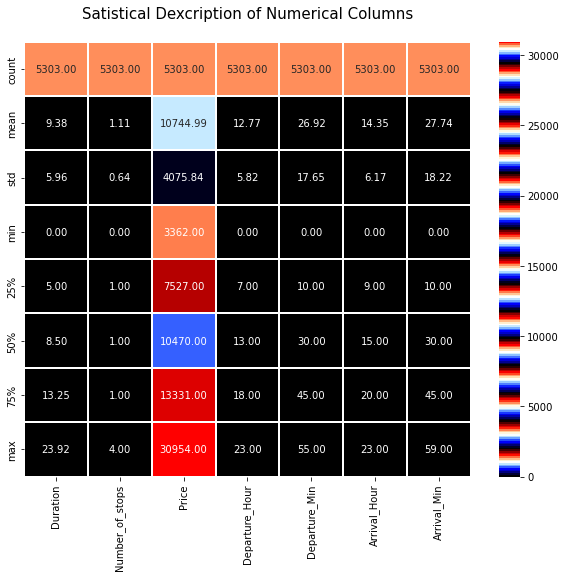

In [25]:
# Visualizing the statistical description of numeric datatype columns

plt.figure(figsize = (10,8))
sns.heatmap(round(df.describe()[0:],2), linewidth = 2, annot= True, fmt = ".2f", cmap="flag_r")
plt.title("Satistical Dexcription of Numerical Columns\n",fontsize=15)

plt.show()

## SEPARATING NUMERICAL AND CATEGORICAL COLUMNS

In [26]:
# Separating numerical and categorcal columns in the dataset

# Checking for categorical columns
categorical_col=[]
for i in df.dtypes.index:
    if df.dtypes[i]=='object':
        categorical_col.append(i)
print("Categorical columns present in the dataset are:\n",categorical_col)

# Now checking for numerical columns
numerical_col=[]
for i in df.dtypes.index:
    if df.dtypes[i]!='object':
        numerical_col.append(i)
print("\nNumerical columns present in the dataset are:\n",numerical_col)



Categorical columns present in the dataset are:
 ['Airline', 'Source', 'Destination', 'Meal_availability']

Numerical columns present in the dataset are:
 ['Duration', 'Number_of_stops', 'Price', 'Departure_Hour', 'Departure_Min', 'Arrival_Hour', 'Arrival_Min']


These are the object data type and numerical type columns present in the dataset. "Number_of_stops" is categorical data since it is in integer type so its appearing as numeric data.

Now it's time to visualize the data.

# EDA (EXPALORATORY DATA ANALYSIS)

### DATA VISUALISATION

Air India    1460
Vistara      1347
IndiGo       1344
Go First      556
Air Asia      416
SpiceJet      180
Name: Airline, dtype: int64 

1    3396
2    1093
0     716
3      94
4       4
Name: Number_of_stops, dtype: int64


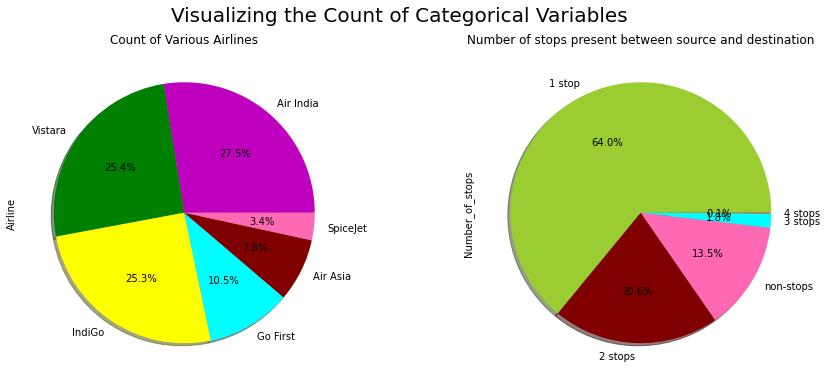

In [27]:
#Univariate Analysis
# Visualizing the count of categorical variables
plt.figure(figsize=(15,6))
plt.suptitle('Visualizing the Count of Categorical Variables',fontsize=20)

# Visualizing the count of Airlines
plt.subplot(1,2,1)
print(df["Airline"].value_counts(),"\n")
plt.title('Count of Various Airlines')
labels = ['Air India', 'Vistara', 'IndiGo', 'Go First', 'Air Asia', 'SpiceJet']
colors = ["m", "green","yellow", "cyan", "maroon", "hotpink"]
df['Airline'].value_counts().plot.pie(autopct='%1.1f%%',shadow=True,labels=labels,fontsize=10,colors=colors)

# Visualizing the count of Number_of_stops
plt.subplot(1,2,2)
print(df['Number_of_stops'].value_counts())
plt.title('Number of stops present between source and destination')
labels = ['1 stop', '2 stops', 'non-stops', '3 stops', '4 stops']
colors = ["yellowgreen","maroon","hotpink","cyan","red"]
df['Number_of_stops'].value_counts().plot.pie(autopct='%1.1f%%',shadow=True,labels=labels,fontsize=10,colors=colors)
plt.show()


Airline: From the pie plot we can infer that there are more number of flights of "Air India", "Vistara" and "Indigo" compared to others. Also, the count of Spicejet flights are very less.

Number_of_stops: From the above pie plot we can infer that 64% of the flights have only 1 stop during the journey and some of the flights (20.6%) have 2 stops where only few flights have 3 and 4 stops.

Free Meal    4701
None          602
Name: Meal_availability, dtype: int64


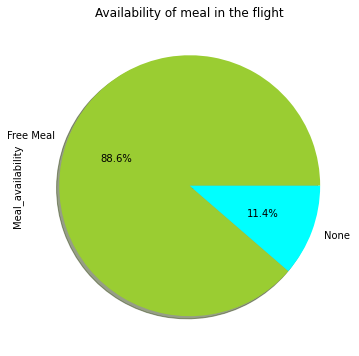

In [28]:
# Visualizing the availability of meal in the flight
plt.figure(figsize=(6,6))
print(df["Meal_availability"].value_counts())
plt.title('Availability of meal in the flight')
labels = ['Free Meal', 'None']
colors = ["yellowgreen","cyan"]
df['Meal_availability'].value_counts().plot.pie(autopct='%1.1f%%',shadow=True,labels=labels,fontsize=10,colors=colors)
plt.show()


Mumbai       816
New Delhi    807
Jaipur       778
Bangalore    738
Kolkata      728
Chennai      553
Goa          529
Hyderabad    354
Name: Source, dtype: int64 

Lucknow      832
New Delhi    734
Mumbai       690
Kolkata      687
Bangalore    624
Chennai      546
Goa          494
Jaipur       405
Hyderabad    291
Name: Destination, dtype: int64


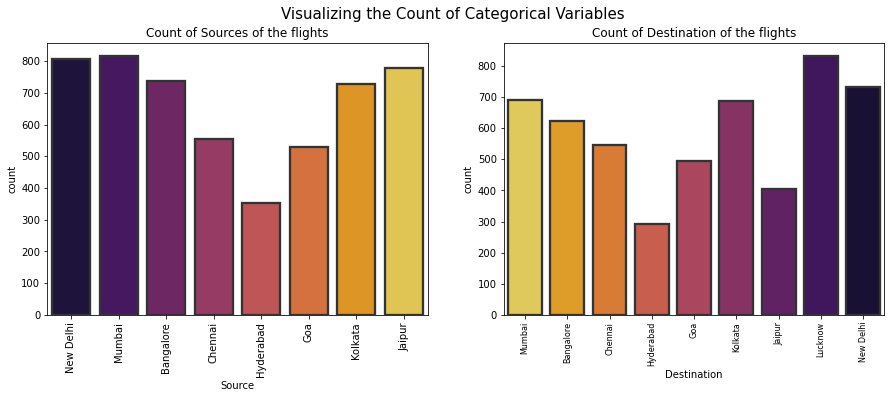

In [29]:
# Visualizing the count of categorical variables
plt.figure(figsize=(15,5))
plt.suptitle('Visualizing the Count of Categorical Variables',fontsize=15)

# Visualizing the count of Sources of the flights
plt.subplot(1,2,1)
print(df['Source'].value_counts(),"\n")
plt.title('Count of Sources of the flights')
sns.countplot('Source', data=df, palette="inferno",linewidth=2.3, edgecolor=".2")
plt.xticks(rotation=90)

# Visualizing the count of Destination of the flights
plt.subplot(1,2,2)
print(df['Destination'].value_counts())
plt.title('Count of Destination of the flights')
sns.countplot('Destination', data=df, palette="inferno_r",linewidth=2.3, edgecolor=".2")
plt.xticks(fontsize='8')
plt.xticks(rotation=90)
plt.show()


Source: From the count plot we can observe more number of flights are from Mumbai, New Delhi, Jaipur, Kolkata and Bangalore. Only few flights are from Hyderabad.

Destination: More number of flights are heading towards Lucknow, New Delhi and Kolkata. Only few flights are travelling to Hyderabad.

## SKEWNESS

#### PLOTTING NUMERICAL VALUE

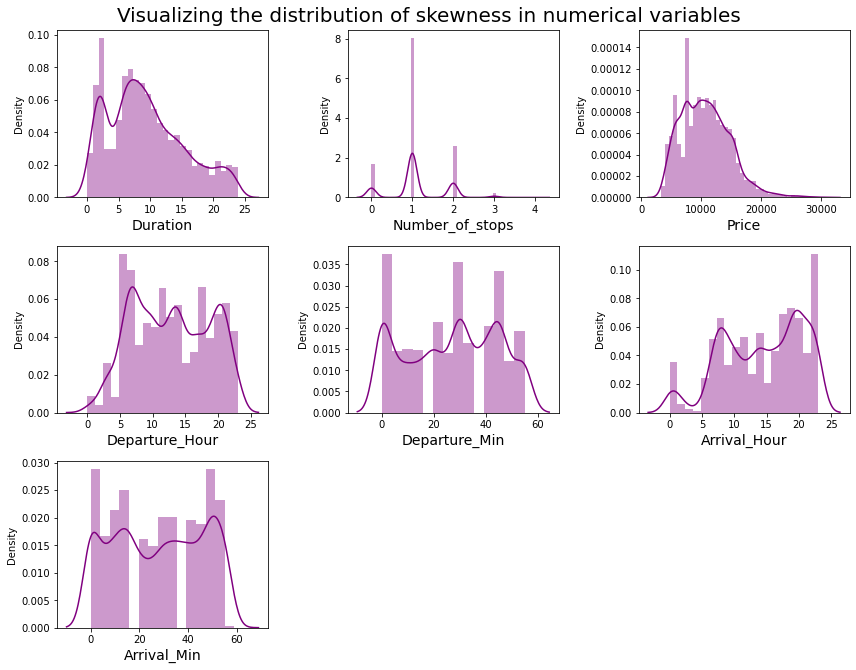

In [30]:
# Checking how the data has been distriubted in each column

plt.figure(figsize=(12,12),facecolor='white')
plt.suptitle("Visualizing the distribution of skewness in numerical variables",fontsize=20)
plotnumber=1
for column in numerical_col:
    if plotnumber<=7:
        ax=plt.subplot(4,3,plotnumber)
        sns.distplot(df[column], color="purple")
        plt.xlabel(column,fontsize=14)
    plotnumber+=1
plt.tight_layout()


Above plot shows how the data has been distributed in each of the columns.

From the distribution plot we can observe the columns are somewhat distributed normally as they have no proper bell shape curve.

The columns like "Duration", "Number_of_stops" and "Price" are skewed to right as the mean value in these columns are much greater than the median(50%).

Also the data in the column Arrival_Hour skewed to left since the mean values is less than the median.

Since there is presence of skewness in the data, we need to remove skewness in the numerical columns to overcome with any kind of data biasness.

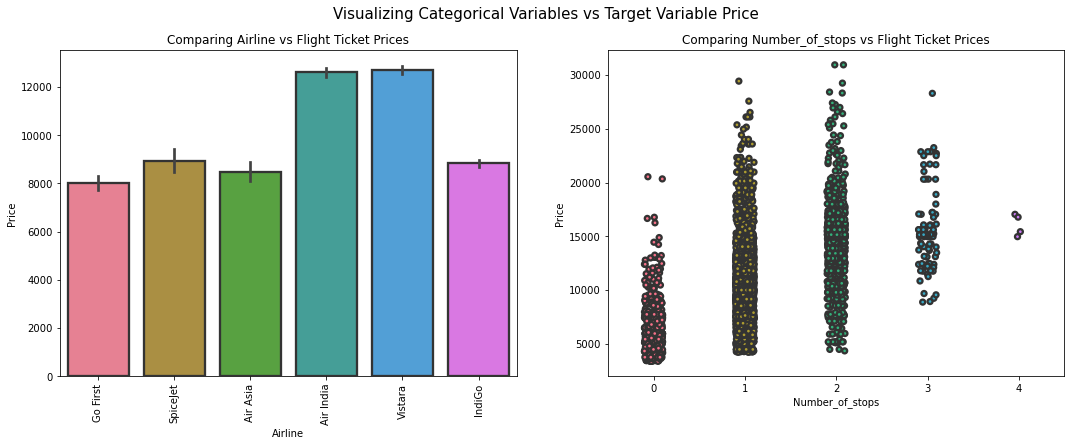

In [31]:
#Bivariate Analysis
#Visualizing Categorical Variables vs Target Variable Price
plt.figure(figsize = (18,6))
plt.suptitle("Visualizing Categorical Variables vs Target Variable Price",fontsize=15)

# Checking which Airline is expensive based on Price of tickets
plt.subplot(1,2,1)
plt.title("Comparing Airline vs Flight Ticket Prices")
sns.barplot(x= df['Airline'],y= df['Price'],palette = "husl",linewidth=2.3, edgecolor=".2")
plt.xticks(rotation = 90)

# Checking flights which have meals availability are expensive or not?
plt.subplot(1,2,2)
plt.title("Comparing Number_of_stops vs Flight Ticket Prices")
sns.stripplot(x = df['Number_of_stops'],y= df['Price'],palette = "husl",linewidth=2.3, edgecolor=".2")
plt.show()

Airline vs Price: From the bar plot we can notice "Vistara" and "Air India" airlines have highest ticket prices compared to other airlines.

Number_of_stops vs Price: From the strip plot we can notice the flights which have 1 and 2 stops between source and destination have highest ticket prices compared to others. The airlines which have 4 stops during the journey have very less ticket price. So we can say as the stops increases, ticket price decreases.

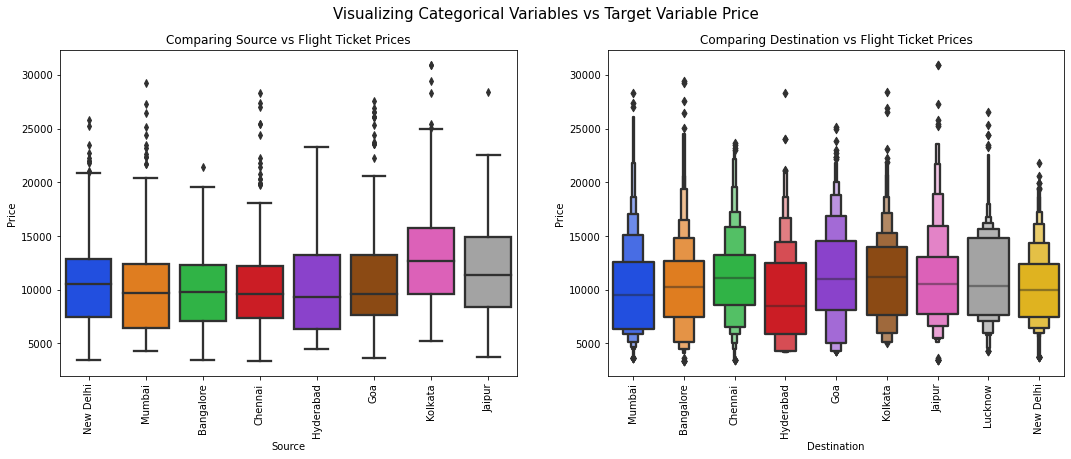

In [32]:
plt.figure(figsize = (18,6))
plt.suptitle("Visualizing Categorical Variables vs Target Variable Price\n",fontsize=15)

# Checking which source has highest ticket price
plt.subplot(1,2,1)
plt.title("Comparing Source vs Flight Ticket Prices")
sns.boxplot(x= df['Source'],y= df['Price'],palette = "bright",linewidth=2.3)
plt.xticks(rotation = 90)

# Checking how prices changes in each destination 
plt.subplot(1,2,2)
plt.title("Comparing Destination vs Flight Ticket Prices")
sns.boxenplot(x = df['Destination'],y= df['Price'],palette = "bright",linewidth=2.3)
plt.xticks(rotation = 90)
plt.show()


Source vs Price: From the box plot we can observe the flights from Kolkata are having somewhat higher prices compared to other sources.

Destination vs Price: From the boxen plot we can notice that the flights travelling to Goa have higher flight ticket prices.

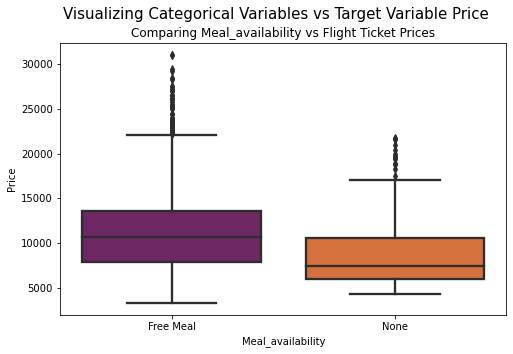

In [33]:
plt.figure(figsize = (8,5))
plt.suptitle("Visualizing Categorical Variables vs Target Variable Price\n",fontsize=15)
plt.title("Comparing Meal_availability vs Flight Ticket Prices")
sns.boxplot(x= df['Meal_availability'],y= df['Price'],palette = "inferno",linewidth=2.3)
plt.show()


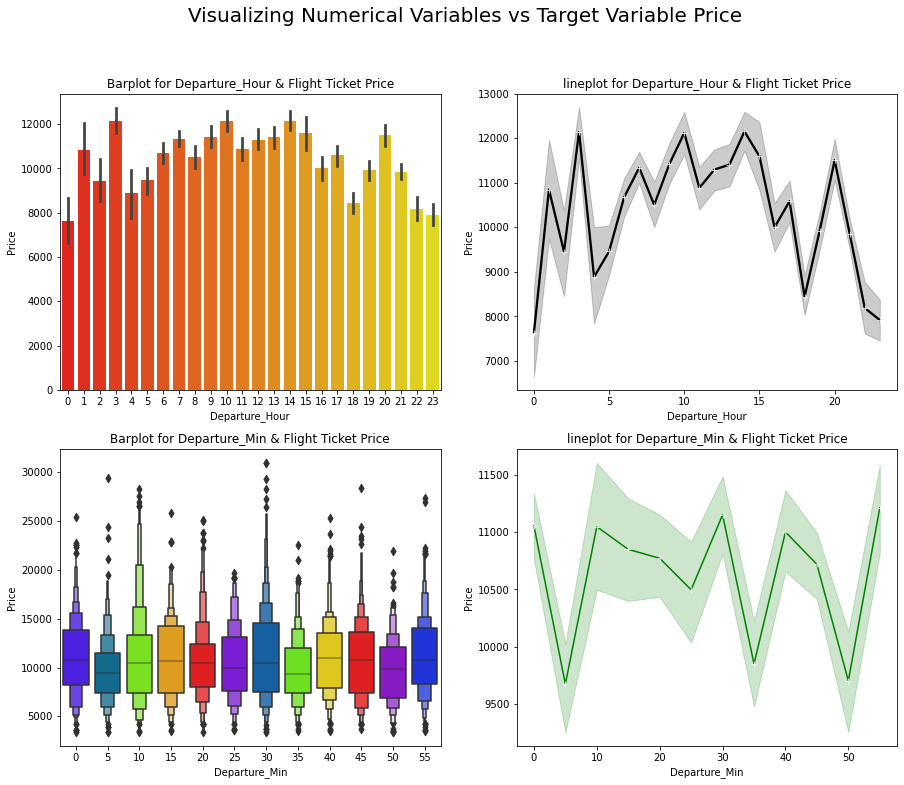

In [34]:
#Visualizing Numerical Variables vs Target Variable Price
plt.figure(figsize = (15,12))
plt.suptitle("Visualizing Numerical Variables vs Target Variable Price",fontsize=20)

plt.subplot(2,2,1)
plt.title("Barplot for Departure_Hour & Flight Ticket Price")
sns.barplot(x= df['Departure_Hour'],y= df['Price'],palette = "autumn",linewidth=2.3)

plt.subplot(2,2,2)
plt.title("lineplot for Departure_Hour & Flight Ticket Price")
sns.lineplot(x = df['Departure_Hour'],y= df['Price'],marker="+",color='k',linewidth=2.3)

plt.subplot(2,2,3)
plt.title("Barplot for Departure_Min & Flight Ticket Price")
sns.boxenplot(x='Departure_Min',y='Price',data=df,palette = "prism",color='k')

plt.subplot(2,2,4)
plt.title("lineplot for Departure_Min & Flight Ticket Price")
sns.lineplot(x='Departure_Min',y='Price',data=df,marker="+",color='g')

plt.show()


Departure_Hour vs Price: From the bar plot and line plot we can see that there are some flights departing in the early morning 3 AM having most expensive ticket prices compared to late morning flights. We can also observe the flight ticket prices are higher during afternoon (may fluctuate) and it decreases in the evening.

Departure_Min vs Price: The boxen plot and line plot gives there is no significant difference between price and departure min.

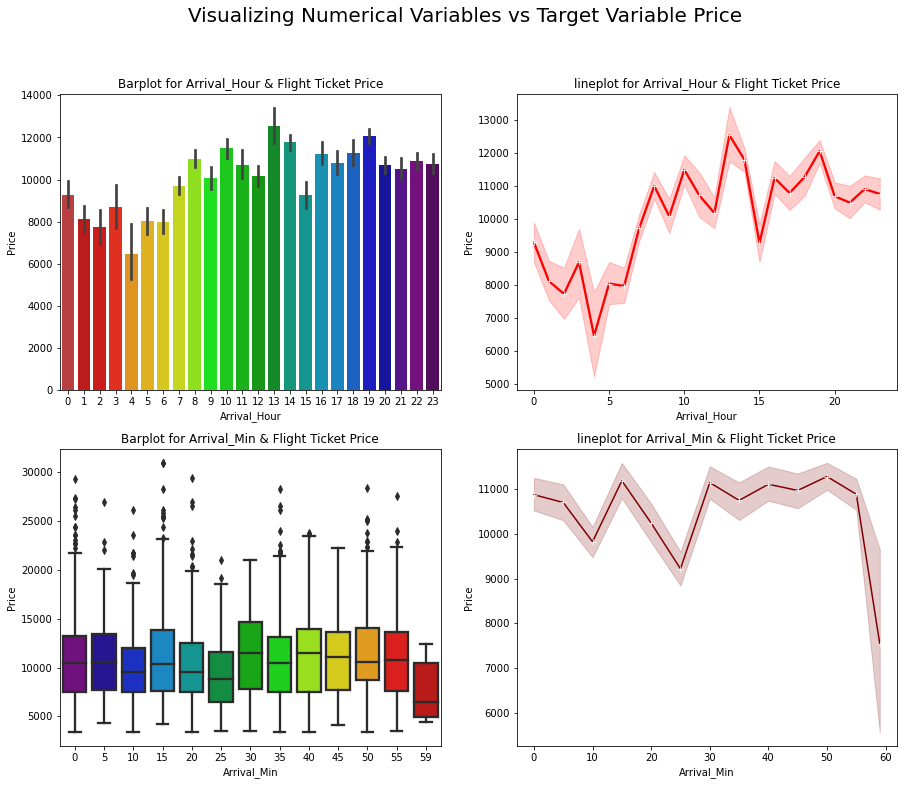

In [35]:
plt.figure(figsize = (15,12))
plt.suptitle("Visualizing Numerical Variables vs Target Variable Price",fontsize=20)

plt.subplot(2,2,1)
plt.title("Barplot for Arrival_Hour & Flight Ticket Price")
sns.barplot(x= df['Arrival_Hour'],y= df['Price'],palette = "nipy_spectral_r",linewidth=2.3)

plt.subplot(2,2,2)
plt.title("lineplot for Arrival_Hour & Flight Ticket Price")
sns.lineplot(x = df['Arrival_Hour'],y= df['Price'],marker="+",color='r',linewidth=2.3)

plt.subplot(2,2,3)
plt.title("Barplot for Arrival_Min & Flight Ticket Price")
sns.boxplot(x='Arrival_Min',y='Price',data=df,palette = "nipy_spectral",linewidth=2.3)

plt.subplot(2,2,4)
plt.title("lineplot for Arrival_Min & Flight Ticket Price")
sns.lineplot(x='Arrival_Min',y='Price',data=df,marker="+",color='maroon')

plt.show()

Arrival_Hour vs Price: From the bar plot and line plot we can observe that very few flights are arriving in the early morning that is 0 to 6 AM they have very less ticket price. Also, the flights which are arriving in the afternoon and evening have somewhat higher price. So, we can conlude this column has some positive correlation with price.

Arrival_Min vs Price: There is no significant difference between this feature and price. We can say flight ticket prices are not much dependent on the Arrival_min.

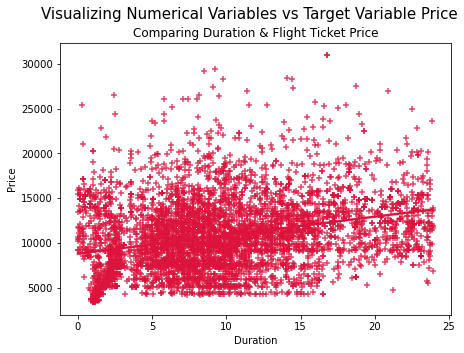

In [36]:
# Visualizing duration and price
plt.figure(figsize = (7,5))
plt.suptitle("Visualizing Numerical Variables vs Target Variable Price",fontsize=15)

plt.title("Comparing Duration & Flight Ticket Price")
sns.regplot(x= df['Duration'],y= df['Price'],marker="+",color='crimson')
plt.show()

Duration vs Price: From the reg plot we can observe some positive linear relation between Duration and Price. Flights having 1-12 hours of duration, they have ticket price of around 10000.


Till now we have checked the relation between the independent variables and dependent variable that is our target column "Price". Now let's check the relation between two independent variables and compare each of them with others.

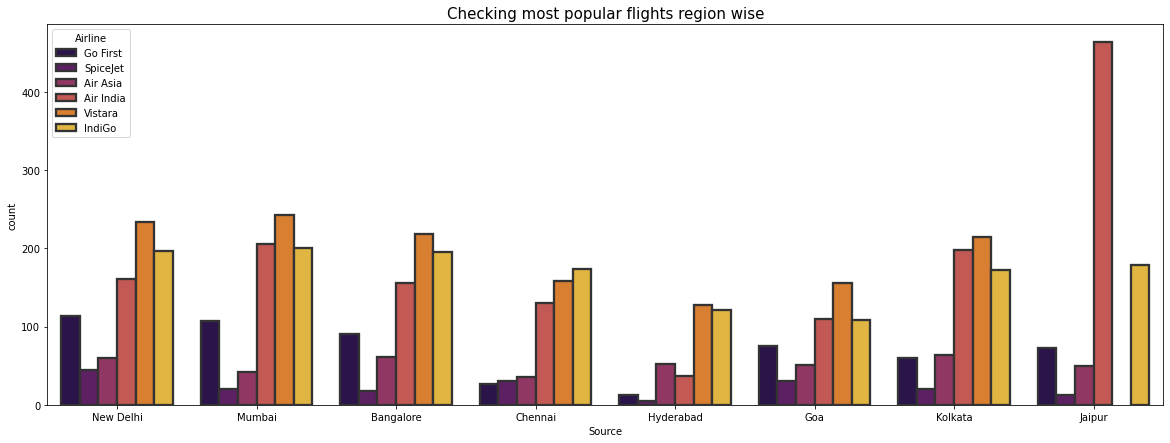

In [37]:
# Lets chcek the most popular flight region wise
plt.figure(figsize=(20,7))
sns.countplot(x = "Source", hue = "Airline", data = df, palette = "inferno",linewidth=2.3, edgecolor=".2")
plt.title("Checking most popular flights region wise",fontsize=15)
plt.show()

Source vs Airline: The plot showing the region wise count of airlines which tells us that Jaipur source is not having Vistara flights and it has Air India flights in higher count compared to other sources. Other sources have Air India, Vistara and Indigo flights with higher count.

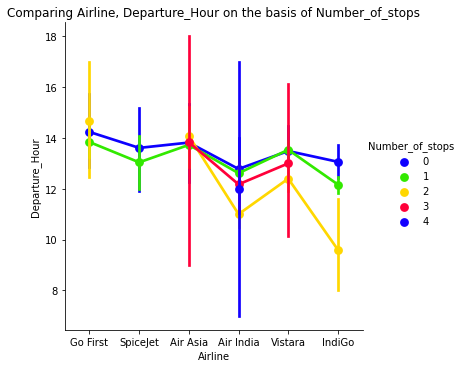

In [38]:
# Lets check the relation between independent variables
sns.factorplot(x= "Airline", y="Departure_Hour",hue="Number_of_stops",palette="prism", data=df)
plt.title("Comparing Airline, Departure_Hour on the basis of Number_of_stops")
plt.show()

Above plot gives the relation between Airline and Departure hour based on Number of stops. Air India and Air Asia flights are departing in the evening and they have less than 4 stops during the journey.

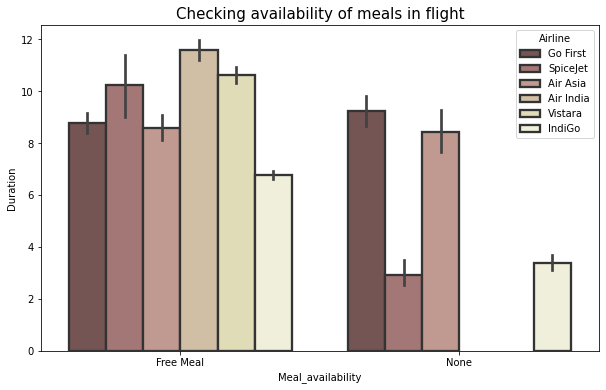

In [39]:
# Lets chcek the most popular flight region wise
plt.figure(figsize=(10,6))
sns.barplot(x = "Meal_availability", y = "Duration",hue="Airline",data = df, palette = "pink",linewidth=2.3, edgecolor=".2")
plt.title("Checking availability of meals in flight",fontsize=15)
plt.show()

All the airlines provides free meals during the journey having the duration below 11 hours.

### MULTIVARIATE ANALYSIS

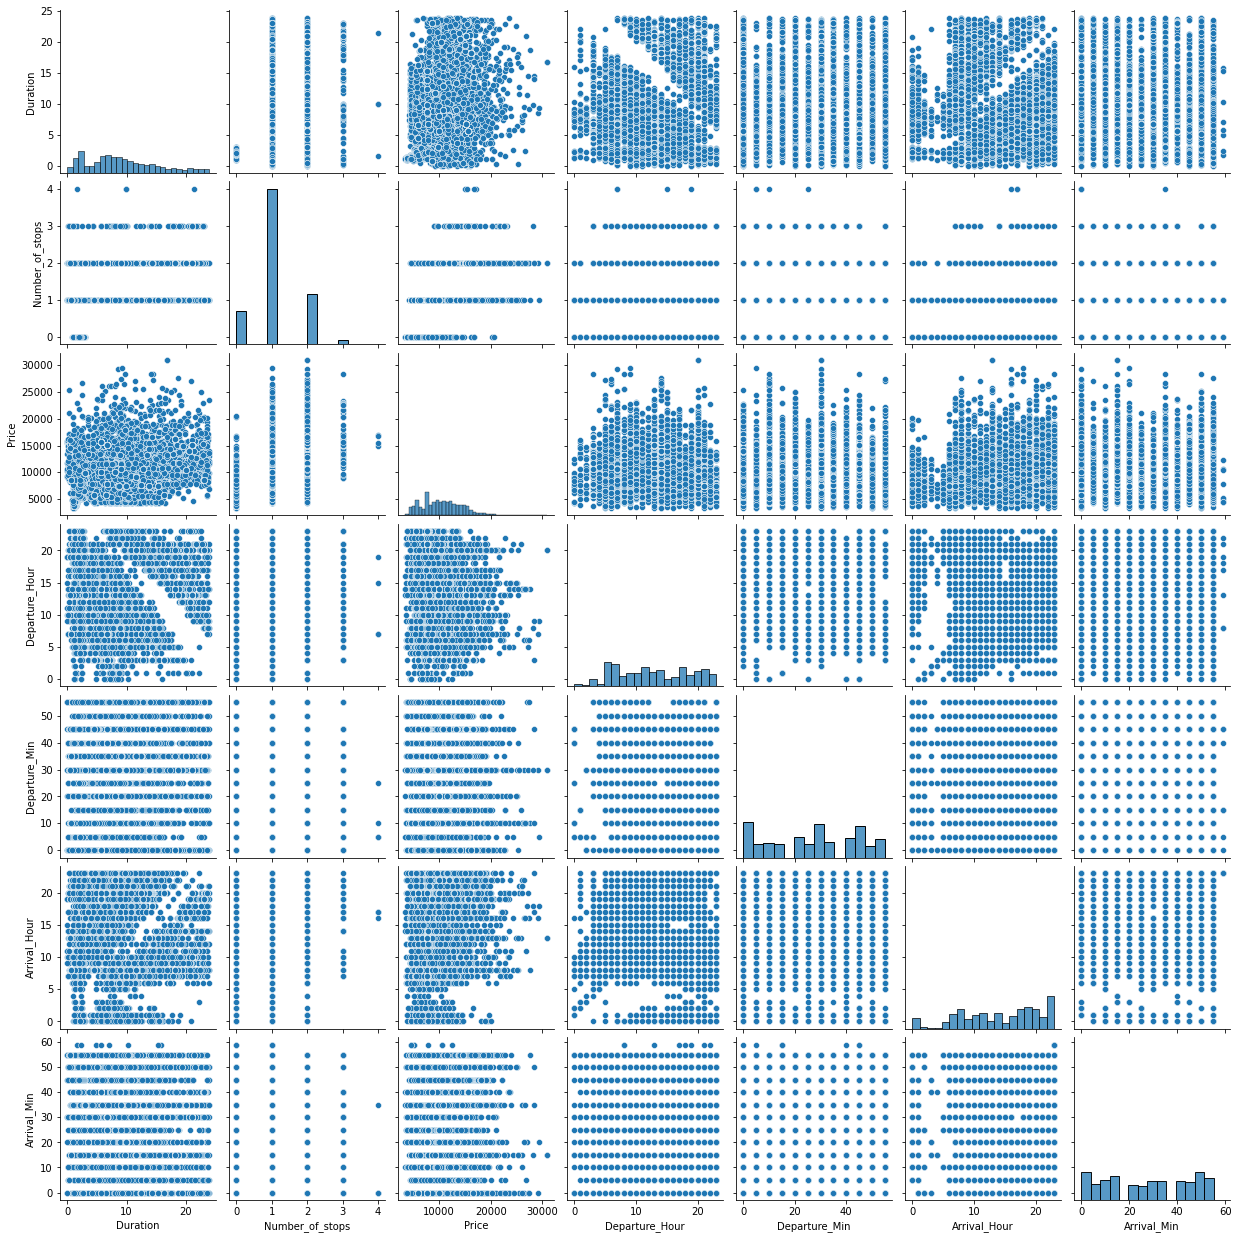

In [40]:
sns.pairplot(df,palette="husl")
plt.show()

This pair plot gives the pairwise relation between the columns which is plotted. Here we can observe the relation between the features and label.

Here we can observe the correaltion between the features and on the diagonal we can notice the distribution plot which shows whether the column has skewness or not.

# EDA Conclusion:
After cleaning the data, we have done the following analysis on the data.

### 1. Do airfares change frequently? Do they move in small increments or in large jumps?

Flight ticket prices change during the morning and evening time of the day. From the distribution plots we came to know that the prices of the flight tickets are going up and down, they are not fixed at a time. Also, from this graph we found prices are increasing in large amounts.

### 2. Do they tend to go up or down over time?

Some flights are departing in the early morning 3 AM having most expensive ticket prices compared to late morning flights. As the time goes the flight ticket fares increased and midnight flight fares are very less (say after 10 PM). Also from categorical and numerical plots we found that the prices tend to go up as the time is approaching from morning to evening.

### 3. What is the best time to buy so that the consumer can save the most by taking the least risk?

From the categorical plots (bar and box) we came to know that early morning and late night flights are cheaper compared to working hours.

### 4. Does price increase as we get near to departure date?

From the categorical plots we found that the flight ticket prices increases as the person get near to departure time. That is last minute flights are very expensive.

### 5. Is Indigo cheaper than Jet Airways?

From the bar plot we got to know that both Indigo and Spicejet airways almost having same ticket fares.

### 6. Are morning flights expensive?

Not all flights are expensive during morning, only few flights departing in the early morning 3 AM are expensive. Apart from this the flight ticket fares are less compared to other timing flight fares.

# DATA PREPROCESSING

### OUTLIERS

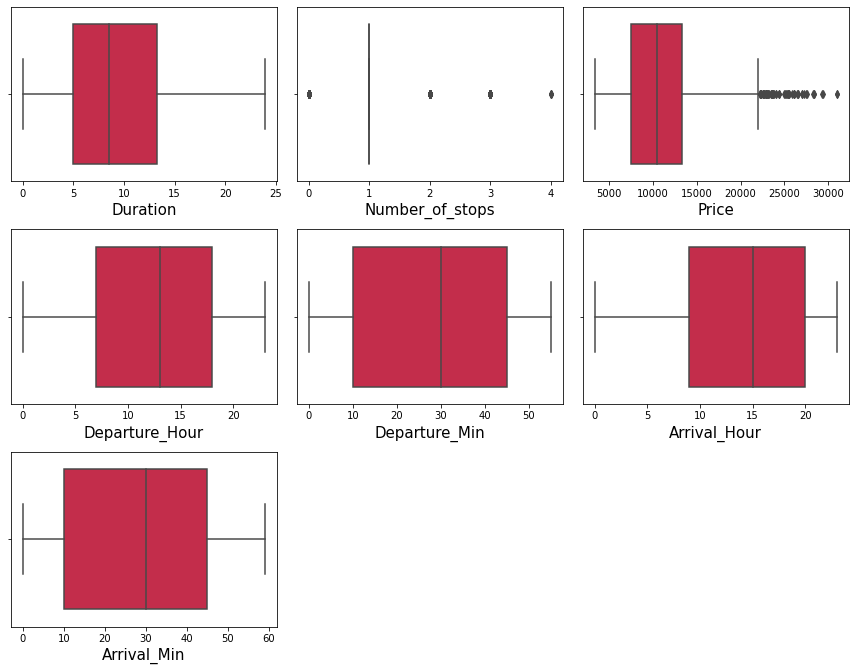

In [41]:
# Identifying the outliers using boxplot

plt.figure(figsize=(12,12),facecolor='white')
plotnumber=1
for column in numerical_col:
    if plotnumber<=7:
        ax=plt.subplot(4,3,plotnumber)
        sns.boxplot(df[column],color="crimson")
        plt.xlabel(column,fontsize=15)
    plotnumber+=1
plt.tight_layout()

The outliers present in Number_of_stops and "Price" columns.
Since Price is our target column and Number_of_stops is our categorical variable so no need to remove outliers in this columns. Finally there is no need to remove outliers in the dataset.

### SKEWNESS

In [42]:
# Checking the skewness
df.skew()

Duration           0.549978
Number_of_stops    0.381915
Price              0.700980
Departure_Hour     0.035683
Departure_Min     -0.116381
Arrival_Hour      -0.418887
Arrival_Min       -0.032736
dtype: float64

We can find the skewness in Duration column and Price column. Price is our target variable we should not loose any data so, no need remove skewness in this column so, let's remove skewness in Duration column.

In [43]:
df["Duration"] = np.sqrt(df["Duration"])

In [44]:
# Again checking the skewness
df.skew()

Duration          -0.154776
Number_of_stops    0.381915
Price              0.700980
Departure_Hour     0.035683
Departure_Min     -0.116381
Arrival_Hour      -0.418887
Arrival_Min       -0.032736
dtype: float64

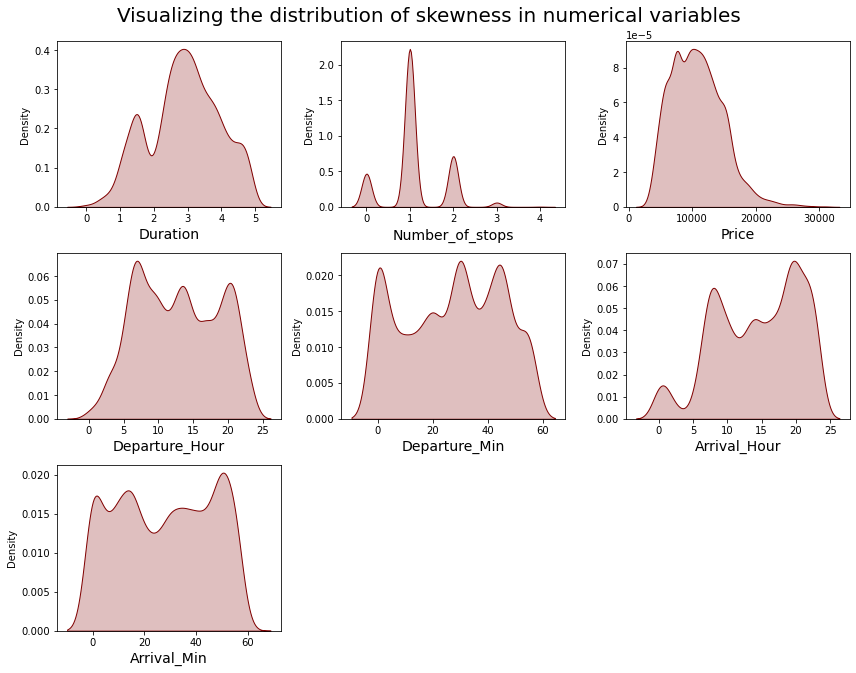

In [45]:
# Checking how the data has been distriubted after removing skewness in the column
plt.figure(figsize=(12,12),facecolor='white')
plt.suptitle("Visualizing the distribution of skewness in numerical variables",fontsize=20)
plotnumber=1
for column in numerical_col:
    if plotnumber<=7:
        ax=plt.subplot(4,3,plotnumber)
        sns.distplot(df[column],hist=False, color="maroon", kde_kws={"shade": True})
        plt.xlabel(column,fontsize=14)
    plotnumber+=1
plt.tight_layout()

## Encoding the categorical columns using Label Encoder Method

In [46]:
# Converting categorical data into numerical using Label Encoder method
from sklearn.preprocessing import LabelEncoder

LE=LabelEncoder()
df[categorical_col]= df[categorical_col].apply(LE.fit_transform)

In [47]:
# Displaying dataframe after encoding 
df

,Airline,Duration,Source,Destination,Meal_availability,Number_of_stops,Price,Departure_Hour,Departure_Min,Arrival_Hour,Arrival_Min
0,2,2.160247,7,7,0,1,4941.0,6,0,10,40
1,2,2.198484,7,7,0,1,4941.0,16,35,21,25
2,2,2.598076,7,7,0,1,4941.0,9,0,15,45
3,2,2.661453,7,7,0,1,4941.0,9,10,16,15
4,2,2.943920,7,7,0,1,4941.0,5,25,14,5
...,...,...,...,...,...,...,...,...,...,...,...
5298,1,2.380476,4,6,0,2,15614.0,14,0,19,40
5299,1,2.380476,4,6,0,3,15614.0,14,0,19,40
5300,1,4.272002,4,6,0,2,16192.0,14,0,8,15
5301,1,4.272002,4,6,0,2,16192.0,14,0,8,15


Now we have converted the categorical columns into numerical columns using label encoding method.

### CORRELATION

In [48]:
# Checking the correlation between features and the target
cor = df.corr()
cor

,Airline,Duration,Source,Destination,Meal_availability,Number_of_stops,Price,Departure_Hour,Departure_Min,Arrival_Hour,Arrival_Min
Airline,1.000000,-0.044873,-0.016840,-0.055112,-0.134730,-0.115706,0.106153,0.032536,0.111513,0.104351,0.175095
Duration,-0.044873,1.000000,-0.039440,-0.003426,-0.156497,0.432166,0.299963,0.081819,-0.000754,-0.029013,-0.021962
Source,-0.016840,-0.039440,1.000000,-0.265382,0.084165,-0.053723,0.093260,-0.020957,-0.060523,-0.014840,0.003363
Destination,-0.055112,-0.003426,-0.265382,1.000000,0.052409,0.001920,-0.034189,-0.001497,0.005001,0.003929,-0.039590
Meal_availability,-0.134730,-0.156497,0.084165,0.052409,1.000000,-0.271619,-0.187175,0.049236,-0.005787,-0.082810,-0.015569
Number_of_stops,-0.115706,0.432166,-0.053723,0.001920,-0.271619,1.000000,0.575886,-0.078935,0.007392,0.068120,-0.010702
Price,0.106153,0.299963,0.093260,-0.034189,-0.187175,0.575886,1.000000,-0.100619,-0.006722,0.124571,0.043381
Departure_Hour,0.032536,0.081819,-0.020957,-0.001497,0.049236,-0.078935,-0.100619,1.000000,-0.019034,-0.103664,0.035249
Departure_Min,0.111513,-0.000754,-0.060523,0.005001,-0.005787,0.007392,-0.006722,-0.019034,1.000000,-0.003594,0.007001
Arrival_Hour,0.104351,-0.029013,-0.014840,0.003929,-0.082810,0.068120,0.124571,-0.103664,-0.003594,1.000000,0.014594


This gives the correlation between the dependent and independent variables. We can visualize this by plotting heat map.

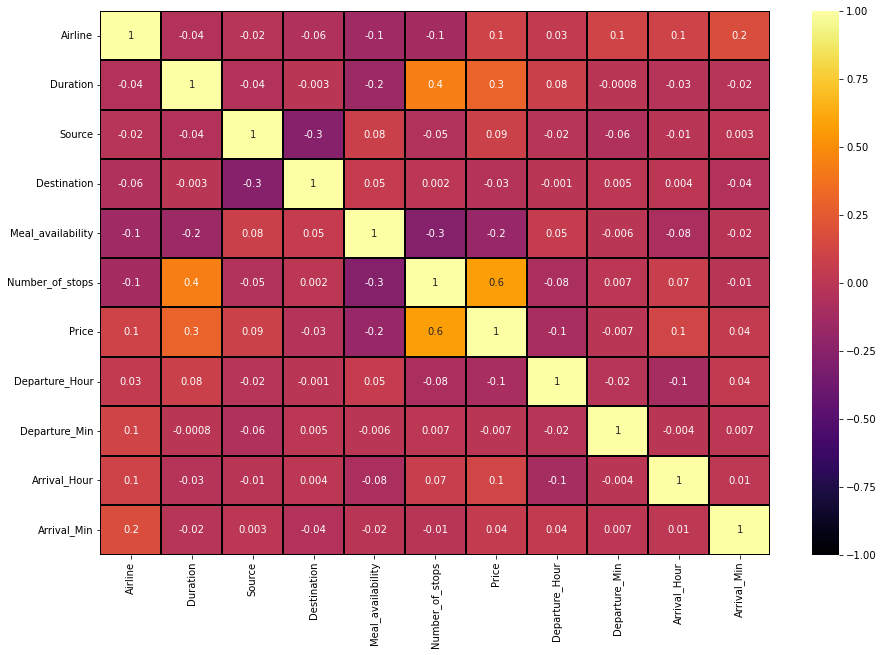

In [49]:
# Visualizing the correlation matrix by plotting heat map.
plt.figure(figsize=(15,10))    
sns.heatmap(df.corr(),linewidths=.1,vmin=-1, vmax=1,fmt='.1g',linecolor="black",annot=True,annot_kws={'size':10},cmap="inferno")
plt.yticks(rotation=0);


This heatmap shows the correlation matrix by visualizing the data. we can observe the relation between one feature to other.

This heat map contains both positive and negative correlation.
The features Number_of_stops, Duration Arrival_Hour and Airline are highly positively correlated with the target column compared to other features.
The other features have very less correlation with the target column.
From the map we can also observe there is no multicollinearity issue that exists.

In [50]:
cor['Price'].sort_values(ascending=False)

Price                1.000000
Number_of_stops      0.575886
Duration             0.299963
Arrival_Hour         0.124571
Airline              0.106153
Source               0.093260
Arrival_Min          0.043381
Departure_Min       -0.006722
Destination         -0.034189
Departure_Hour      -0.100619
Meal_availability   -0.187175
Name: Price, dtype: float64

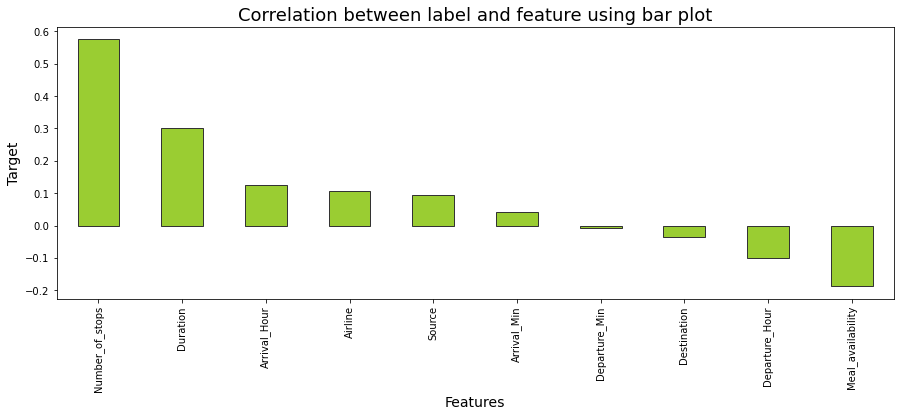

In [51]:
#Visualizing the correlation between label and features using bar plot
plt.figure(figsize=(15,5))
df.corr()['Price'].sort_values(ascending=False).drop(['Price']).plot(kind='bar',color='yellowgreen',edgecolor=".2")
plt.xlabel('Features',fontsize=14)
plt.ylabel('Target',fontsize=14)
plt.title('Correlation between label and feature using bar plot',fontsize=18)
plt.show()

From the bar plot we can clearly observe the positive and negative correlation between the label and features. Here the column "Meal_availability" has less correlation with the label compared to other features, we can drop this column if necessary but for now let's keep it as it is.

### Separating the feature and label into x and y

In [52]:
x = df.drop("Price", axis=1)
y = df["Price"]

In [53]:
# Dimension of x and y
x.shape, y.shape

((5303, 10), (5303,))

### FEATURE SCALING

In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
x.head()


,Airline,Duration,Source,Destination,Meal_availability,Number_of_stops,Departure_Hour,Departure_Min,Arrival_Hour,Arrival_Min
0,-0.386354,-0.691761,1.354839,0.978349,-0.357852,-0.170556,-1.163362,-1.525801,-0.704815,0.672770
1,-0.386354,-0.655020,1.354839,0.978349,-0.357852,-0.170556,0.555252,0.457853,1.079413,-0.150444
2,-0.386354,-0.271065,1.354839,0.978349,-0.357852,-0.170556,-0.647778,-1.525801,0.106198,0.947175
3,-0.386354,-0.210168,1.354839,0.978349,-0.357852,-0.170556,-0.647778,-0.959043,0.268400,-0.699253
4,-0.386354,0.061245,1.354839,0.978349,-0.357852,-0.170556,-1.335224,-0.108906,-0.056005,-1.248063


## MODEL BUILDING/MACHINE LEARNING

In [55]:
from sklearn.ensemble import RandomForestRegressor
maxAccu=0
maxRS=0
for i in range(1,200):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.30, random_state=i)
    mod = RandomForestRegressor()
    mod.fit(x_train, y_train)
    pred = mod.predict(x_test)
    acc=r2_score(y_test, pred)
    if acc>maxAccu:
        maxAccu=acc
        maxRS=i
print("Maximum r2 score is ",maxAccu," on Random_state ",maxRS)

Maximum r2 score is  0.7447819570809215  on Random_state  126


With the help of random state selection process we have found our random state to be 126 amongst 1-1000 with best accuracy as 74.1643% for test size=0.3 using Random Forest Regressor.

### FEATURE IMPORTANCE

In [56]:
# Lets chkeck the feature importance using Random Forest Regressor

RFR = RandomForestRegressor()
RFR.fit(x_train, y_train)
importances = pd.DataFrame({'Features':x.columns, 'Importance':np.round(RFR.feature_importances_,3)})
importances = importances.sort_values('Importance', ascending=False).set_index('Features')
importances

,Importance
Features,
Number_of_stops,0.333
Airline,0.125
Source,0.098
Duration,0.090
Departure_Hour,0.078
Departure_Min,0.075
Destination,0.073
Arrival_Hour,0.063
Arrival_Min,0.054


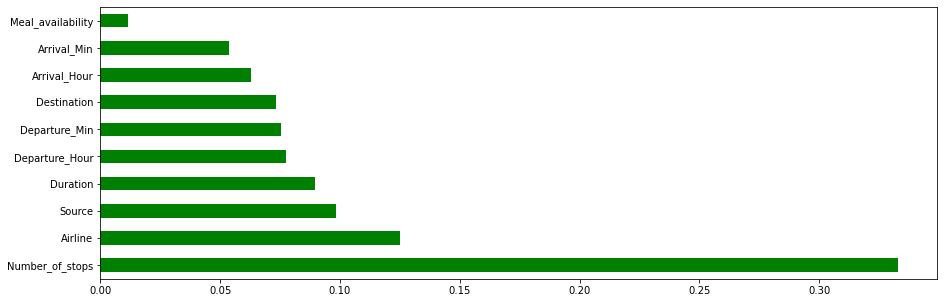

In [57]:
plt.figure(figsize=(15,5))
importances=pd.Series(RFR.feature_importances_,index=x.columns)
importances.nlargest(30).plot(kind='barh',color="g")
plt.show()

Here with the help of RandomForestRegressor we are able to list down the importance given to a column as per it's involvement in predicting our label. Here the column "Number_of_stops", "Airline" and "Source" contributing more for prediction which means these features are important for the predictions.

#### TRAIN TEST SPLIT

In [58]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=53)

We are taking 20 percent of the complete dataset for training purpose and the remaining 80 percent will be used to train the machine learning models using the random state.

In [59]:
x_train.shape

(4242, 10)

In [60]:
x_test.shape

(1061, 10)

In [61]:
y_train.shape

(4242,)

In [62]:
y_test.shape

(1061,)

### MACHINE LEARNING  REGRESSION ALGORITHM

In [63]:
# importing all the required libraries
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso,Ridge,ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

In [64]:
# creating a function to run all the regressors

def regressor(model, x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=53)
    
    # Training the model
    model.fit(x_train, y_train)
    
    # Predicting y_test
    pred = model.predict(x_test)
    
    # Root Mean Square Error (RMSE)
    rmse = mean_squared_error(y_test, pred, squared=False)
    print("Root Mean Square Error is:", rmse)
    
    # R2 score
    r2 = r2_score(y_test, pred, multioutput='variance_weighted')*100
    print("R2 Score is:", r2)
    
    # Cross Validation Score
    cv_score = (cross_val_score(model, x, y, cv=5).mean())*100
    print("Cross Validation Score is:", cv_score)
    
    # Result of r2 score - cv score
    result = r2 - cv_score
    print("R2 Score - Cross Validation Score is", result)

In [65]:
# LINEAR REGRESSION
model=LinearRegression()
regressor(model, x, y)

Root Mean Square Error is: 3102.8186536791522
R2 Score is: 42.60323434610594
Cross Validation Score is: 33.77319916855067
R2 Score - Cross Validation Score is 8.830035177555274


In [66]:
# L1 -- Lasso Regression

model=Lasso(alpha=0.001)
regressor(model, x, y)


Root Mean Square Error is: 3102.818672494132
R2 Score is: 42.603233650016925
Cross Validation Score is: 33.773211683967105
R2 Score - Cross Validation Score is 8.83002196604982


In [67]:
# L2 -- Ridge Regression

model=Ridge(alpha=0.001)
regressor(model, x, y)

Root Mean Square Error is: 3102.8186264525643
R2 Score is: 42.603235353395284
Cross Validation Score is: 33.77319922834114
R2 Score - Cross Validation Score is 8.830036125054143


In [68]:
# Elastic Net

model=ElasticNet(alpha=0.001)
regressor(model, x, y)

Root Mean Square Error is: 3102.7613800512713
R2 Score is: 42.605353252187726
Cross Validation Score is: 33.77331900837605
R2 Score - Cross Validation Score is 8.832034243811677


In [69]:
# Support Vector Regression

model=SVR(kernel='rbf')
regressor(model, x, y)

Root Mean Square Error is: 4063.649859839265
R2 Score is: 1.5519329273662064
Cross Validation Score is: -5.9147846244282976
R2 Score - Cross Validation Score is 7.466717551794504


In [70]:
model=SVR(kernel='poly')
regressor(model, x, y)

Root Mean Square Error is: 4012.093509020631
R2 Score is: 4.034147452280323
Cross Validation Score is: -3.3886265089246232
R2 Score - Cross Validation Score is 7.422773961204946


In [71]:
model=SVR(kernel='linear')
regressor(model, x, y)

Root Mean Square Error is: 3284.6518314452705
R2 Score is: 35.67892171494081
Cross Validation Score is: 27.576797084658228
R2 Score - Cross Validation Score is 8.102124630282585


In [72]:
#Decision Tree Regressor

model=DecisionTreeRegressor()
regressor(model, x, y)

Root Mean Square Error is: 2730.4035061799655
R2 Score is: 55.55444856660181
Cross Validation Score is: -11.460460298043147
R2 Score - Cross Validation Score is 67.01490886464497


In [73]:
#Random Forest Regressor

model=RandomForestRegressor()
regressor(model, x, y)

Root Mean Square Error is: 2001.3157831346437
R2 Score is: 76.12156422395572
Cross Validation Score is: 40.0239490649399
R2 Score - Cross Validation Score is 36.09761515901582


In [74]:
#K Neighbors Regressor

model=KNeighborsRegressor()
regressor(model, x, y)

Root Mean Square Error is: 2761.4439108347187
R2 Score is: 54.53815197360785
Cross Validation Score is: 23.548905410763474
R2 Score - Cross Validation Score is 30.98924656284438


In [75]:
#SGD Regressor

model=SGDRegressor()
regressor(model, x, y)

Root Mean Square Error is: 3106.820361297551
R2 Score is: 42.45508957030658
Cross Validation Score is: 33.569508306396266
R2 Score - Cross Validation Score is 8.885581263910318


In [76]:
#Gradient Boosting Regressor

model=GradientBoostingRegressor()
regressor(model, x, y)

Root Mean Square Error is: 2478.865429653122
R2 Score is: 63.36632108788558
Cross Validation Score is: 44.70777507452549
R2 Score - Cross Validation Score is 18.658546013360088


In [77]:
#Ada Boost Regressor

model=AdaBoostRegressor()
regressor(model, x, y)

Root Mean Square Error is: 3607.4693986791517
R2 Score is: 22.414610555265956
Cross Validation Score is: 6.170087645854185
R2 Score - Cross Validation Score is 16.24452290941177


In [78]:
#Extra Trees Regressor

model=ExtraTreesRegressor()
regressor(model, x, y)

Root Mean Square Error is: 1920.3782172587237
R2 Score is: 78.01390120184166
Cross Validation Score is: 40.34511718318612
R2 Score - Cross Validation Score is 37.66878401865554


In [79]:
#Extreme Gradient Boosting Regressor (XGB)

from xgboost import XGBRegressor as xgb
model=xgb()
regressor(model, x, y)

Root Mean Square Error is: 2071.6548978729247
R2 Score is: 74.41358409017838
Cross Validation Score is: 34.17089069885046
R2 Score - Cross Validation Score is 40.24269339132792


Model Selection
From the above created models, Extra Trees Regressor algorithm has high R2 score and less RMSE value. So, we can conclude that "Extra Trees Regressor" as the best fitting model. Let's try to increase our model score by tuning the best model using different types of hyper parameters

### HYPER PARAMETER TUNING

In [80]:
# Let's Use the GridSearchCV to find the best paarameters in XGBRegressor
from sklearn.model_selection import GridSearchCV

# Extra Trees Regressor
parameters = {'n_estimators':[10,100,200],
             'criterion':['squared_error','mse','absolute_error','mae'],
             'min_samples_split': [1,2,3],
             'max_features':['auto','sqrt','log2'],
             'n_jobs':[-2,-1,1]}

In [81]:
GCV = GridSearchCV(ExtraTreesRegressor(), parameters, cv=5)

In [82]:
# Running GridSearchCV
GCV.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=ExtraTreesRegressor(),
             param_grid={'criterion': ['squared_error', 'mse', 'absolute_error',
                                       'mae'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [10, 100, 200],
                         'n_jobs': [-2, -1, 1]})

In [83]:
GCV.best_params_  

{'criterion': 'mae',
 'max_features': 'auto',
 'min_samples_split': 3,
 'n_estimators': 100,
 'n_jobs': -1}

### FINAL MODEL

In [84]:
final_model = ExtraTreesRegressor(criterion = 'mae', max_features = 'auto', min_samples_split = 2, n_estimators = 100, n_jobs = 1)

In [85]:
final_fit = final_model.fit(x_train,y_train)   # final fit

In [86]:
final_pred = final_model.predict(x_test)   # predicting with best parameters

In [87]:
best_r2=r2_score(y_test,final_pred,multioutput='variance_weighted')*100   # checking final r2_score
print("R2 score for the Best Model is:", best_r2)

R2 score for the Best Model is: 78.63428563933101


In [88]:
final_cv_score = (cross_val_score(final_model, x, y, cv=5).mean())*100
print("Cross Validation Score is:", final_cv_score)

Cross Validation Score is: 39.858894514096285


In [89]:
final_rmse = mean_squared_error(y_test, final_pred, squared=False)
print("Root Mean Square Error is:", final_rmse)

Root Mean Square Error is: 1893.0905716794111


We used Hyper Parameter Tuning on the final model to obtained the best r2_score and CV score.

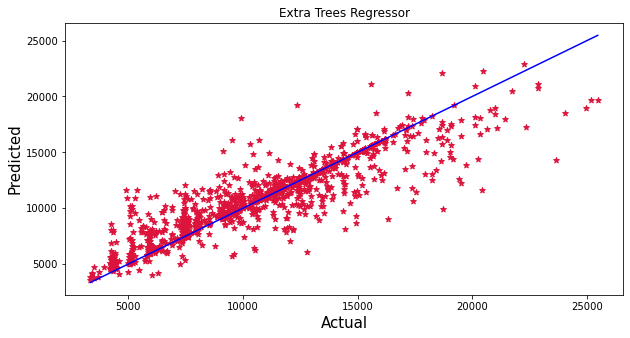

In [91]:
# Visualizing actual and predicted values
plt.figure(figsize=(10,5))
plt.scatter(y_test, final_pred, c='crimson',marker="*")
p1 = max(max(final_pred), max(y_test))
p2 = min(min(final_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual', fontsize=15)
plt.ylabel('Predicted', fontsize=15)
plt.title("Extra Trees Regressor")
plt.show()

The graph shows how our final model is mapping. The plot gives the linear relation between predicted and actual price of the Flight Prices

####  SAVING THE FINAL MODEL

In [94]:
# Saving the model using joblib library 
import joblib
joblib.dump(final_model,"Flight_Ticket_Price_Prediction.pkl")

['Flight_Ticket_Price_Prediction.pkl']

In [95]:
# Loading the saved model
Model=joblib.load("Flight_Ticket_Price_Prediction.pkl")

#Prediction
prediction = Model.predict(x_test)
prediction

array([14549.39, 14377.  ,  8032.03, ...,  9692.26, 10323.8 , 10348.64])

In [96]:
#Creating DataFrame for the predicted values

Predicted_Flight_Ticket_Price = pd.DataFrame([Model.predict(x_test)[:],y_test[:]],index=["Predicted","Actual"])
Predicted_Flight_Ticket_Price

,0,1,2,3,4,5,6,7,8,9,...,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060
Predicted,14549.39,14377.0,8032.03,8681.11,16066.62,8755.45,7346.3,7086.87,11549.45,8702.9,...,16484.0,10125.21,11485.39,17127.29,12500.11,8358.97,11580.24,9692.26,10323.8,10348.64
Actual,19028.00,14377.0,4262.00,7907.00,10721.00,8055.00,7133.0,6489.00,12486.00,8577.0,...,17304.0,6932.00,14839.00,16140.00,12616.00,7982.00,14976.00,9730.00,9277.0,11691.00


# CONCLUSION

Key Findings and Conclusion of the Study:
The case study aims to give an idea of applying Machine Learning algorithms to predict the price of the flight tickets. After the completion of this project, we got an insight of how to collect data, pre-processing the data, analyze the data, cleaning the data and building a model.

First we collected the flights data from website yatra and it was done by using Web scraping. The framework used for web scraping was Selenium, which has an advantage of automating our process of collecting data. We collected almost 5303 of data which contained the ticket price of the flights and other related features. Then, the scrapped data was saved in a excel file so that we can use further and analyse the data.

Then we loaded the dataset and have done data cleaning, EDA process and pre-processing techniques like checking outliers, skewness, correlation, scaling data etc and got better insights from data visualization.

From the visualizations we have done some analysis which I have mentioned already in the EDA conclusion part. 

_____________________________________________________________________________________________________________________________

After separating our train and test data, we started running different machine learning regression algorithms to find out the best performing model on the basis of different metrics like R2 Score, Mean Absolute Error, Mean Squared Error, Root Mean Squared Error. We tried many algorithms like Linear, Lasso, Ridge, Elastic Net, Support Vector, Decision Tree, Random Forest, K Neighbors, SGD, Gradient Boosting, Ada Boost, Extra Trees and Extreme Gradient Boosting (XGB) Regressor.

We got Extra Trees Regressor as the best model among all the models as it was giving high R2 score and the low evaluation metrics compared to other models. On this basis we performed the Hyperparameter tuning to finding out the best parameter. So we concluded that Extra Trees Regressor as the best algorithm as it was giving high R2 score.

After that we saved the model in a pickle with a file name in order to use whenever we require. Then we loaded the saved file and predicted the values.

Overall, we can conclude that Extra Trees Regressor is the best working algorithm model we obtained. We can improve the data and R2 score by adding some more features to the dataset.